# Spatial cross correlation analysis  for health data

Here we use spatial indices, such as Moran index and Gini coefficients for estimation of spatial autocorrelation function.
Methodology is partiallly inspired by "A New Methodology of Spatial Cross-Correlation Analysis" Chen, Plos One.

Algorithm:
0. load data from wards and shapes
1. preprocess the data 
2. apply spatial measures

In [1]:
import os
import json
import requests
from datetime import datetime
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import numpy
import matplotlib
from matplotlib import pyplot as plt

import geopandas as gp

# 0. load data for wards   

In [2]:

#filepath = "C:/Users/tupikina/Documents/Datasets/Dataward/2010_Ward_dosage_symptom_prevalence.json"

filepath ="C:/Users/lyubo/Documents/DATA_networks/health_Data/Data_ward/2010_Ward_dosage_symptom_prevalence.json"
#"C:/Users/tupikina/Documents/Datasets/Dataward/2010_Ward_dosage_symptom_prevalence.json"


with open(filepath) as f:
    ward_symp2010_data = json.load(f)
#ward_2010_data

df_symp2010 = pd.DataFrame(ward_symp2010_data)
df_symp2010.head(10)


,indigestion,suicidal,constipation,edema,heartburn,joint pain,dementia,parkinson's disease,muscle pain,irritable bowel syndrome,...,arthritis,asthenia,tremor,nausea,chronic pain,anxiety,parkinsonism,depressive disorder,weight gain,urinary incontinence
prev,"{'E05002284': 0.04209103122829294, 'E05007241'...","{'E05002284': 0.0, 'E05007241': 0.0, 'E0500090...","{'E05002284': 0.912893620814043, 'E05007241': ...","{'E05002284': 8.272813670624556, 'E05007241': ...","{'E05002284': 3.4725010672528756, 'E05007241':...","{'E05002284': 0.02928660773148875, 'E05007241'...","{'E05002284': 0.012638047978888792, 'E05007241...","{'E05002284': 0.4767939281799032, 'E05007241':...","{'E05002284': 1.0913832358828631e-05, 'E050072...","{'E05002284': 0.00181044609035238, 'E05007241'...",...,"{'E05002284': 1.5059581259458237, 'E05007241':...","{'E05002284': 0.00022123118671358753, 'E050072...","{'E05002284': 0.02905532300645714, 'E05007241'...","{'E05002284': 0.3894245348701383, 'E05007241':...","{'E05002284': 0.24247972905079174, 'E05007241'...","{'E05002284': 6.0266957734377185, 'E05007241':...","{'E05002284': 0.009098313915499657, 'E05007241...","{'E05002284': 0.34208116685693324, 'E05007241'...","{'E05002284': 0.023822336865076052, 'E05007241...","{'E05002284': 1.7383436755480564e-06, 'E050072..."
Id,162031009,267073005,14760008,267038008,16331000,57676002,52448006,49049000,68962001,10743008,...,3723001,13791008,26079004,422587007,82423001,48694002,32798002,35489007,8943002,165232002


In [7]:
df_symp2010.indigestion.iloc[0]

{'E05002284': 0.04209103122829294,
 'E05007241': 0.11370411361573597,
 'E05000900': 0.19525502700320468,
 'E05000901': 0.25474778206672005,
 'E05000902': 0.18406868273902738,
 'E05000903': 0.13304669601131353,
 'E05000904': 0.24854176936005562,
 'E05000905': 0.18090878271402583,
 'E05000906': 0.22319557537171683,
 'E05000907': 0.1261510879531796,
 'E05000908': 0.1539091918392319,
 'E05000909': 0.2350152802499533,
 'E05003228': 0.15853935160366175,
 'E05003229': 0.15399955386000053,
 'E05011023': 0.09346873378489733,
 'E05011022': 0.10824968730650276,
 'E05011025': 0.12595879279535355,
 'E05011024': 0.16860252130487122,
 'E05011027': 0.11218373804712663,
 'E05011026': 0.08874244481236732,
 'E05003220': 0.10276619470055168,
 'E05003221': 0.0555831367938182,
 'E05003222': 0.10312718442692932,
 'E05003223': 0.09706478606479504,
 'E05003224': 0.1519216427372658,
 'E05003225': 0.16724395203461792,
 'E05003226': 0.16552113678883407,
 'E05003227': 0.15362076361744958,
 'E05010166': 0.029175986

# 1. Preprocessing data from wards and shape files 
Here we first load ward variable from data.


In [3]:

# get all values of dictionary from wards 

#1. get dictionary from column c = 0 or 1 depending on dataframe
suic_vals = df_symp2010.suicidal.iloc[0].values()
edema_vals = df_symp2010.edema.iloc[0].values()
heartburn_vals = df_symp2010.heartburn.iloc[0].values()


col = 0 # column of dataframe with all nonzero values

#2. arrays of data for symptoms from dictionary
var_suic = np.array(list(df_symp2010.suicidal.iloc[col].values())) #np.array(list(suic_vals))
var_edema = np.array(list(df_symp2010.edema.iloc[col].values())) #np.array(list(edema_vals))
var_heartburn = np.array(list(df_symp2010.heartburn.iloc[col].values())) # np.array(list(heartburn_vals ))
var_indiges = np.array(list(df_symp2010.indigestion.iloc[col].values()))
var_dement = np.array(list(df_symp2010.dementia.iloc[col].values()))



print('shape of array with data with symptoms ', np.shape(var_heartburn))

# calculate weighted spatial matrix for wards from shape files
# W matrix from shape file

# get array of ward names 
key_wards = np.array(df_symp2010.suicidal.iloc[col].keys())
print('type of key wards ', type(key_wards))
#print('all keys', key_wards)


shape of array with data with symptoms  (7427,)
type of key wards  <class 'numpy.ndarray'>


# 0. Load shape file on spatial structure 
We first import shape files. 
Then we will look at wards data and estimate spatial structure differences. 
df_symp2010.indigestion.iloc[0]

In [4]:


import pandas as pd
import geopandas as gpd
import pysal.lib as lps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

file_path_shape = "C:/Users/lyubo/Documents/DATA_networks/health_Data/Wards_December_2016_Full_Extent_Boundaries_in_Great_Britain/Wards_December_2016_Full_Extent_Boundaries_in_Great_Britain.shp"

#read dataframe of shape file
shapefile = gpd.read_file(file_path_shape)
#pth = pysal.lib.examples.get_path(file_path_shape)

# Loading ward variable from data
# get all values of dictionary from wards 
shapefile.head()

,objectid,wd16cd,wd16nm,wd16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E05000026,Abbey,None,E09000002,Barking and Dagenham,544434,184378,0.081291,51.539822,1.282923e+06,6244.885511,"POLYGON ((545296.396 184162.603, 545109.299 18..."
1,2,E05000027,Alibon,None,E09000002,Barking and Dagenham,549247,185196,0.150987,51.545921,1.364443e+06,6353.928980,"POLYGON ((547932.400 184916.597, 547944.800 18..."
2,3,E05000028,Becontree,None,E09000002,Barking and Dagenham,546863,185869,0.116912,51.552601,1.288085e+06,6341.644591,"POLYGON ((546209.396 185783.599, 546219.299 18..."
3,4,E05000029,Chadwell Heath,None,E09000002,Barking and Dagenham,548266,189340,0.138596,51.583420,3.384195e+06,9603.313795,"POLYGON ((548881.002 191087.601, 548877.300 19..."
4,5,E05000030,Eastbrook,None,E09000002,Barking and Dagenham,550774,186272,0.173453,51.555191,3.450579e+06,8987.707165,"POLYGON ((551552.897 187363.397, 551554.802 18..."


# 1. Preprocessing data 
Functions to put together wards and shape dataframes
by adding values of shape files of wards to symptoms dataframe.



In [9]:



def geometry_ward(ward_key, df_shape):
    
    '''# given ward_key from dataframe df 
    # returns geometry value for that ward '''
    
    #ward_names = df_shape.wd16cd.values    
    
    #To select rows whose column value equals a scalar, some_value, use ==:
    df_ward = df_shape.loc[df_shape['wd16cd'] == ward_key]
    return df_ward.geometry.values
    
def symp_ward(ward_key, df, column_numb): #): 
    '''# given :
    1. ward_key from dataframe df df_symp2010;
    2. column_numb, where symptom is located in initial dataframe
    # returns symptom value for that ward '''
    
    row = 0
    
    #1. get dictionary from column c = 0 or 1 depending on dataframe
    edema_vals = df_symp2010.iloc[row,column_numb] #df_symp2010.edema.iloc[row] # 

    #print(type(edema_vals))
    
    return edema_vals.get(ward_key)#edema_vals[ward_key]
    

In [11]:
#test
ward_key = 'E05000028'
df_ward = shapefile.loc[shapefile['wd16cd'] == ward_key]
print(type(df_ward.geometry.values))


symp_ward('E05002284', df_symp2010, 0) #reply should be E05002284

<class 'geopandas.array.GeometryArray'>


0.04209103122829294

# 1. Preprocessing data 

Here we create new dataframe from geoshape file plus symptoms. 
We add values of symptoms to separate column of geospatial file. 

In [6]:
df_shape_symp = shapefile

# add new column to dataframe 
df_shape_symp.columns

shape = df_shape_symp.shape
print(shape)

# Using DataFrame.insert() to add a column 
df_shape_symp.insert(3,"symp_edema", np.zeros(shape[0]), True) 

df_shape_symp.insert(3,"symp_heartburn", np.zeros(shape[0]), True) 

df_shape_symp.insert(4,"symp_indigest", np.zeros(shape[0]), True) 
  
df_shape_symp.head()    
#df_new_shape.columns = [ 'objectid', 'wd16cd', 'wd16nm', 'wd16nmw', 'lad16cd', 'lad16nm',        'bng_e', 'bng_n', 'long', 'lat', 'st_areasha', 'st_lengths',       'geometry', 'symp_1']

(8668, 13)


,objectid,wd16cd,wd16nm,symp_heartburn,symp_indigest,symp_edema,wd16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E05000026,Abbey,0.0,0.0,0.0,None,E09000002,Barking and Dagenham,544434,184378,0.081291,51.539822,1.282923e+06,6244.885511,"POLYGON ((545296.396 184162.603, 545109.299 18..."
1,2,E05000027,Alibon,0.0,0.0,0.0,None,E09000002,Barking and Dagenham,549247,185196,0.150987,51.545921,1.364443e+06,6353.928980,"POLYGON ((547932.400 184916.597, 547944.800 18..."
2,3,E05000028,Becontree,0.0,0.0,0.0,None,E09000002,Barking and Dagenham,546863,185869,0.116912,51.552601,1.288085e+06,6341.644591,"POLYGON ((546209.396 185783.599, 546219.299 18..."
3,4,E05000029,Chadwell Heath,0.0,0.0,0.0,None,E09000002,Barking and Dagenham,548266,189340,0.138596,51.583420,3.384195e+06,9603.313795,"POLYGON ((548881.002 191087.601, 548877.300 19..."
4,5,E05000030,Eastbrook,0.0,0.0,0.0,None,E09000002,Barking and Dagenham,550774,186272,0.173453,51.555191,3.450579e+06,8987.707165,"POLYGON ((551552.897 187363.397, 551554.802 18..."


# Function to insert values into dataframe
Insert symptoms values to new dataframe with shape files. 

Change in the function symp_ward() the symptom name, e.g. symp_ward and column name from dataframe df_symp2010.

In [13]:
#array of all wards names in geo-shape file
ward_name_array = np.array(shapefile.wd16cd.values)

col = 0 # column of dataframe with all nonzero values

key_wards = list(df_symp2010.edema.iloc[col].keys())
key_wards_indig = list(df_symp2010.indigestion.iloc[col].keys())


print('shape of key_wards from symptoms dataframe', len(key_wards))
symp_dic_edem = {}    #create dictionary of symptoms
symp_dic_indig = {}

# make loop through all ward names from symtoms dataframe

for ind in range(0, len(ward_name_array)):
    ward_key = ward_name_array[ind]
    #print('ward key', ward_key)
    
    #geom = geometry_ward(ward_key, shapefile)
    column_numb_edem = 3
    symp_dic_edem.update({ward_key : np.float64(symp_ward(ward_key, df_symp2010, column_numb_edem)) }) #append dictionary of symptoms shapes
    #print(type(np.float64(symp_ward(ward_key, df_symp2010)))) #print data type
    
    column_numb_indig = 0#number of column in df_symp2010 with indigestion
    symp_dic_indig.update({ward_key : np.float64(symp_ward(ward_key, df_symp2010, column_numb_indig))}) #symp_ward(ward_key, df_symp2010))})

#print('dictionary of symptoms', symp_dic)
# add symptoms of edema to dataframe df_shape_symp 
#df_shape_symp.symp_1 = symp_dic.values()


#array = symp_dic.values()
#array_float = np.float64(symp_dic.values())
#print(array_float )


print('adding edema symptoms to the dataframe')
df_shape_symp.symp_edema = symp_dic_edem.values()
df_shape_symp.symp_indigest = symp_dic_indig.values()

df_shape_symp.head()

shape of key_wards from symptoms dataframe 7427
adding edema symptoms to the dataframe


,objectid,wd16cd,wd16nm,symp_heartburn,symp_indigest,symp_edema,wd16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E05000026,Abbey,0.0,0.084478,4.399939,None,E09000002,Barking and Dagenham,544434,184378,0.081291,51.539822,1.282923e+06,6244.885511,"POLYGON ((545296.396 184162.603, 545109.299 18..."
1,2,E05000027,Alibon,0.0,0.120316,8.588602,None,E09000002,Barking and Dagenham,549247,185196,0.150987,51.545921,1.364443e+06,6353.928980,"POLYGON ((547932.400 184916.597, 547944.800 18..."
2,3,E05000028,Becontree,0.0,0.108782,8.579117,None,E09000002,Barking and Dagenham,546863,185869,0.116912,51.552601,1.288085e+06,6341.644591,"POLYGON ((546209.396 185783.599, 546219.299 18..."
3,4,E05000029,Chadwell Heath,0.0,0.092600,8.044955,None,E09000002,Barking and Dagenham,548266,189340,0.138596,51.583420,3.384195e+06,9603.313795,"POLYGON ((548881.002 191087.601, 548877.300 19..."
4,5,E05000030,Eastbrook,0.0,0.136991,9.404271,None,E09000002,Barking and Dagenham,550774,186272,0.173453,51.555191,3.450579e+06,8987.707165,"POLYGON ((551552.897 187363.397, 551554.802 18..."


# Mask dataframe for nonzero elements
Filter missing values from dataframe df_shape_symp.
Since we have many missing values, we can first mask dataframe for the values, where df_shape_symp.symp_edema is nonzero


In [21]:
# first lets count number of zero values in the 
print('nonzero values', np.nonzero(df_shape_symp.symp_edema.values))
print('nonzero values', np.count_nonzero(df_shape_symp.symp_edema.values))
print('nonzero values', np.shape(df_shape_symp.symp_edema.values))

print('since we have many missing values, we can first mask dataframe for the values, where df_shape_symp.symp_edema is nonzero')

# filter dataframe

print('detect NAN values and drop them for column "symp_edema"')
#series = pd.isna(df_shape_symp['symp_edema'])
#df_shape_symp_new = df_shape_symp['symp_edema'].dropna()#df_shape_symp.mask(series)
#df_shape_symp_new.shape

df_shape_symp_new = df_shape_symp[df_shape_symp['symp_edema'].notna()] #df_shape_symp.dropna()
df_shape_symp_new = df_shape_symp[df_shape_symp['symp_indigest'].notna()]
print(df_shape_symp_new.shape)
print('type of dataframe symptoms values', type(df_shape_symp_new['symp_edema'].iloc[1]))

nonzero values (array([   0,    1,    2, ..., 8665, 8666, 8667], dtype=int64),)
nonzero values 8668
nonzero values (8668,)
since we have many missing values, we can first mask dataframe for the values, where df_shape_symp.symp_edema is nonzero
detect NAN values and drop them for column "symp_edema"
(7426, 16)
type of dataframe symptoms values <class 'numpy.float64'>


# Create new dataframe from ward values plus spatial information 
## (this is additional dataframe)
Add spatial information about polygons for each ward with symptoms. 


In [45]:

# Create the pandas DataFrame 
df_new_wards = pd.DataFrame(columns = ['wards','symptom_suic','symptom_edema', 'geometry']) 
  
# Put ward names 
df_new_wards.wards =df_symp2010.suicidal.iloc[col].keys()

df_new_wards.head()
print(df_new_wards.shape)


# make loop through all ward names from symtoms dataframe

#ward_name_array = np.array(shapefile.wd16cd.values)

key_wards = list(df_symp2010.suicidal.iloc[col].keys())
print('shape of key_wards from symptoms dataframe', len(key_wards))
geom = {}    #create dictionary of shapes

for ind in range(0, len(key_wards)):
    ward_key = ward_name_array[ind]
    #print('ward key', ward_key)
    
    #geom = geometry_ward(ward_key, shapefile)
    geom.update({ward_key : geometry_ward(ward_key, shapefile) }) #append dictionary of geometry shapes
    
    
    
print('done with looping through key wards')
#print(geom)

# get values of dictionary of polygons 
#print(geom.values())

# include values of dictionary of polygons to new dataframe of symptoms 
df_new_wards.geometry = geom.values()

df_new_wards.head()


# add symptom values to new dataframe 

key_wards = list(df_symp2010.suicidal.iloc[col].keys())
print('shape of key_wards from symptoms dataframe', len(key_wards))

geom = {}    #create dictionary of shapes

var_suic = np.array(list(df_symp2010.suicidal.iloc[col].values())) #np.array(list(suic_vals))
var_edema = np.array(list(df_symp2010.edema.iloc[col].values()))

df_new_wards.symptom_suic = var_suic
df_new_wards.symptom_edema = var_edema

df_new_wards.head()
   
    
    
print(type(df_new_wards.geometry))

print(df_new_wards.geometry.apply(type))
    

(7427, 4)


# 2. Estimate spatial weights matrix from shape file 
We estimate weights matrix $W$ from the initial (very imporant) shape file dataframe with added columns with symptoms e.g. dataframe df_shape_symp_new 

There may be some errors in files due to the missing values or due to islands (some wards can be islands and may not have neighbors).

In [45]:
#load data with shape file

#from pysal.lib.weights import Queen, Rook, KNN

wq =  lps.weights.Queen.from_dataframe(df_shape_symp_new) #also done for dataframe df_shape_symp_new and df_shape_symp 
wq.transform = 'r'

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [ ]:

# should be done for dataframe df_shape_symp 

#wq_wards =  lps.weights.Queen.from_dataframe(df_shape_symp_new)
#wq_wards.transform = 'r'



Further analysis I need to verify with another notebook 
/Documents/PYTHON/pysal-master/notebooks/explore/esda/Spatial Autocorrelation for Areal Unit Data.ipynb

In [19]:
print('weighted matrix', wq)

weighted matrix <pysal.lib.weights.contiguity.Queen object at 0x0000027DD07ADBA8>


# Plotting shape files

The shape file has number of wards, e.g. E05002284, which are in wd16cd names.

We plot values for edema as the distribution of wards values across England.

In [46]:
df_shape_symp_new.head()

,objectid,wd16cd,symp_edema,symp_heartburn,wd16nm,wd16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E05000026,4.39994,0.0,Abbey,None,E09000002,Barking and Dagenham,544434,184378,0.081291,51.539822,1.282923e+06,6244.885511,"POLYGON ((545296.396 184162.603, 545109.299 18..."
1,2,E05000027,8.5886,0.0,Alibon,None,E09000002,Barking and Dagenham,549247,185196,0.150987,51.545921,1.364443e+06,6353.928980,"POLYGON ((547932.400 184916.597, 547944.800 18..."
2,3,E05000028,8.57912,0.0,Becontree,None,E09000002,Barking and Dagenham,546863,185869,0.116912,51.552601,1.288085e+06,6341.644591,"POLYGON ((546209.396 185783.599, 546219.299 18..."
3,4,E05000029,8.04496,0.0,Chadwell Heath,None,E09000002,Barking and Dagenham,548266,189340,0.138596,51.583420,3.384195e+06,9603.313795,"POLYGON ((548881.002 191087.601, 548877.300 19..."
4,5,E05000030,9.40427,0.0,Eastbrook,None,E09000002,Barking and Dagenham,550774,186272,0.173453,51.555191,3.450579e+06,8987.707165,"POLYGON ((551552.897 187363.397, 551554.802 18..."


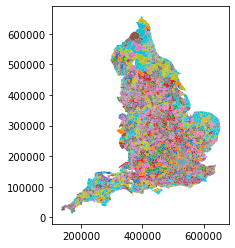

In [47]:
df_shape_symp_new.plot(column= 'symp_edema')# 'st_areasha')
plt.title('edema wards distribution')

In [ ]:

df_shape_symp.plot(column='symp_edema')

# Modules to study spatial correlation between variables
Here we can use two modules for studying spatial correlations: 
1. libpysal (also works with shape files)
2. pysal (it requires geopandas and special installation)


Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

We use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

For this we will need to estimate spatial weights. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial closeness. As we have seen there
are many ways to define spatial weights. We will use queen contiguity.

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

# Moran index

We calculate Moran's I. A test for global autocorrelation for a attribute of wards with attributes symptom values.

Definition of Moran index for two spatially distributed variables $F_1,F_2$ is based on **attribute similarity**: $ MI =F_1 W F_2$.

# Lagged Moran index 


**Important comment:** values of cells should be of type <class 'numpy.float64'> not <float>!

In [55]:
from pysal.explore.esda.moran import Moran

value = df_shape_symp_new['symp_edema'].iloc[1]
print(value)
print(type(value))

print(type(df_shape_symp_new['symp_edema']))


8.588601547587801
<class 'float'>
<class 'pandas.core.series.Series'>


In [70]:
y = df_shape_symp_new['symp_edema']#.values()
ylag = lps.weights.lag_spatial(wq, y)




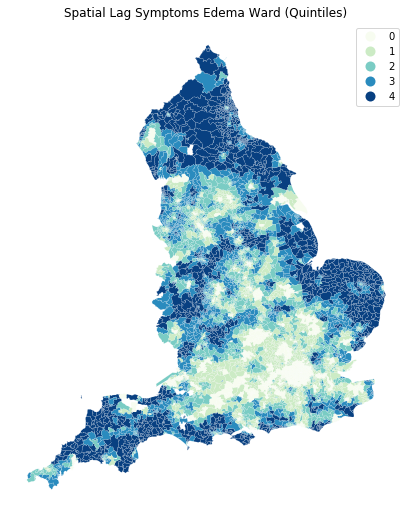

In [73]:

from pysal.viz import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

f, ax = plt.subplots(1, figsize=(9, 9))
df_shape_symp_new.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)

ax.set_axis_off()
plt.title("Spatial Lag Symptoms Edema Ward (Quintiles)")

plt.show()

In [74]:
df_shape_symp_new['lag_edema'] = ylag


C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Quantile map
Here we plot the quintile map for the spatial lag - to enhance the impression of value similarity in space. It is, in effect, a local smoother.


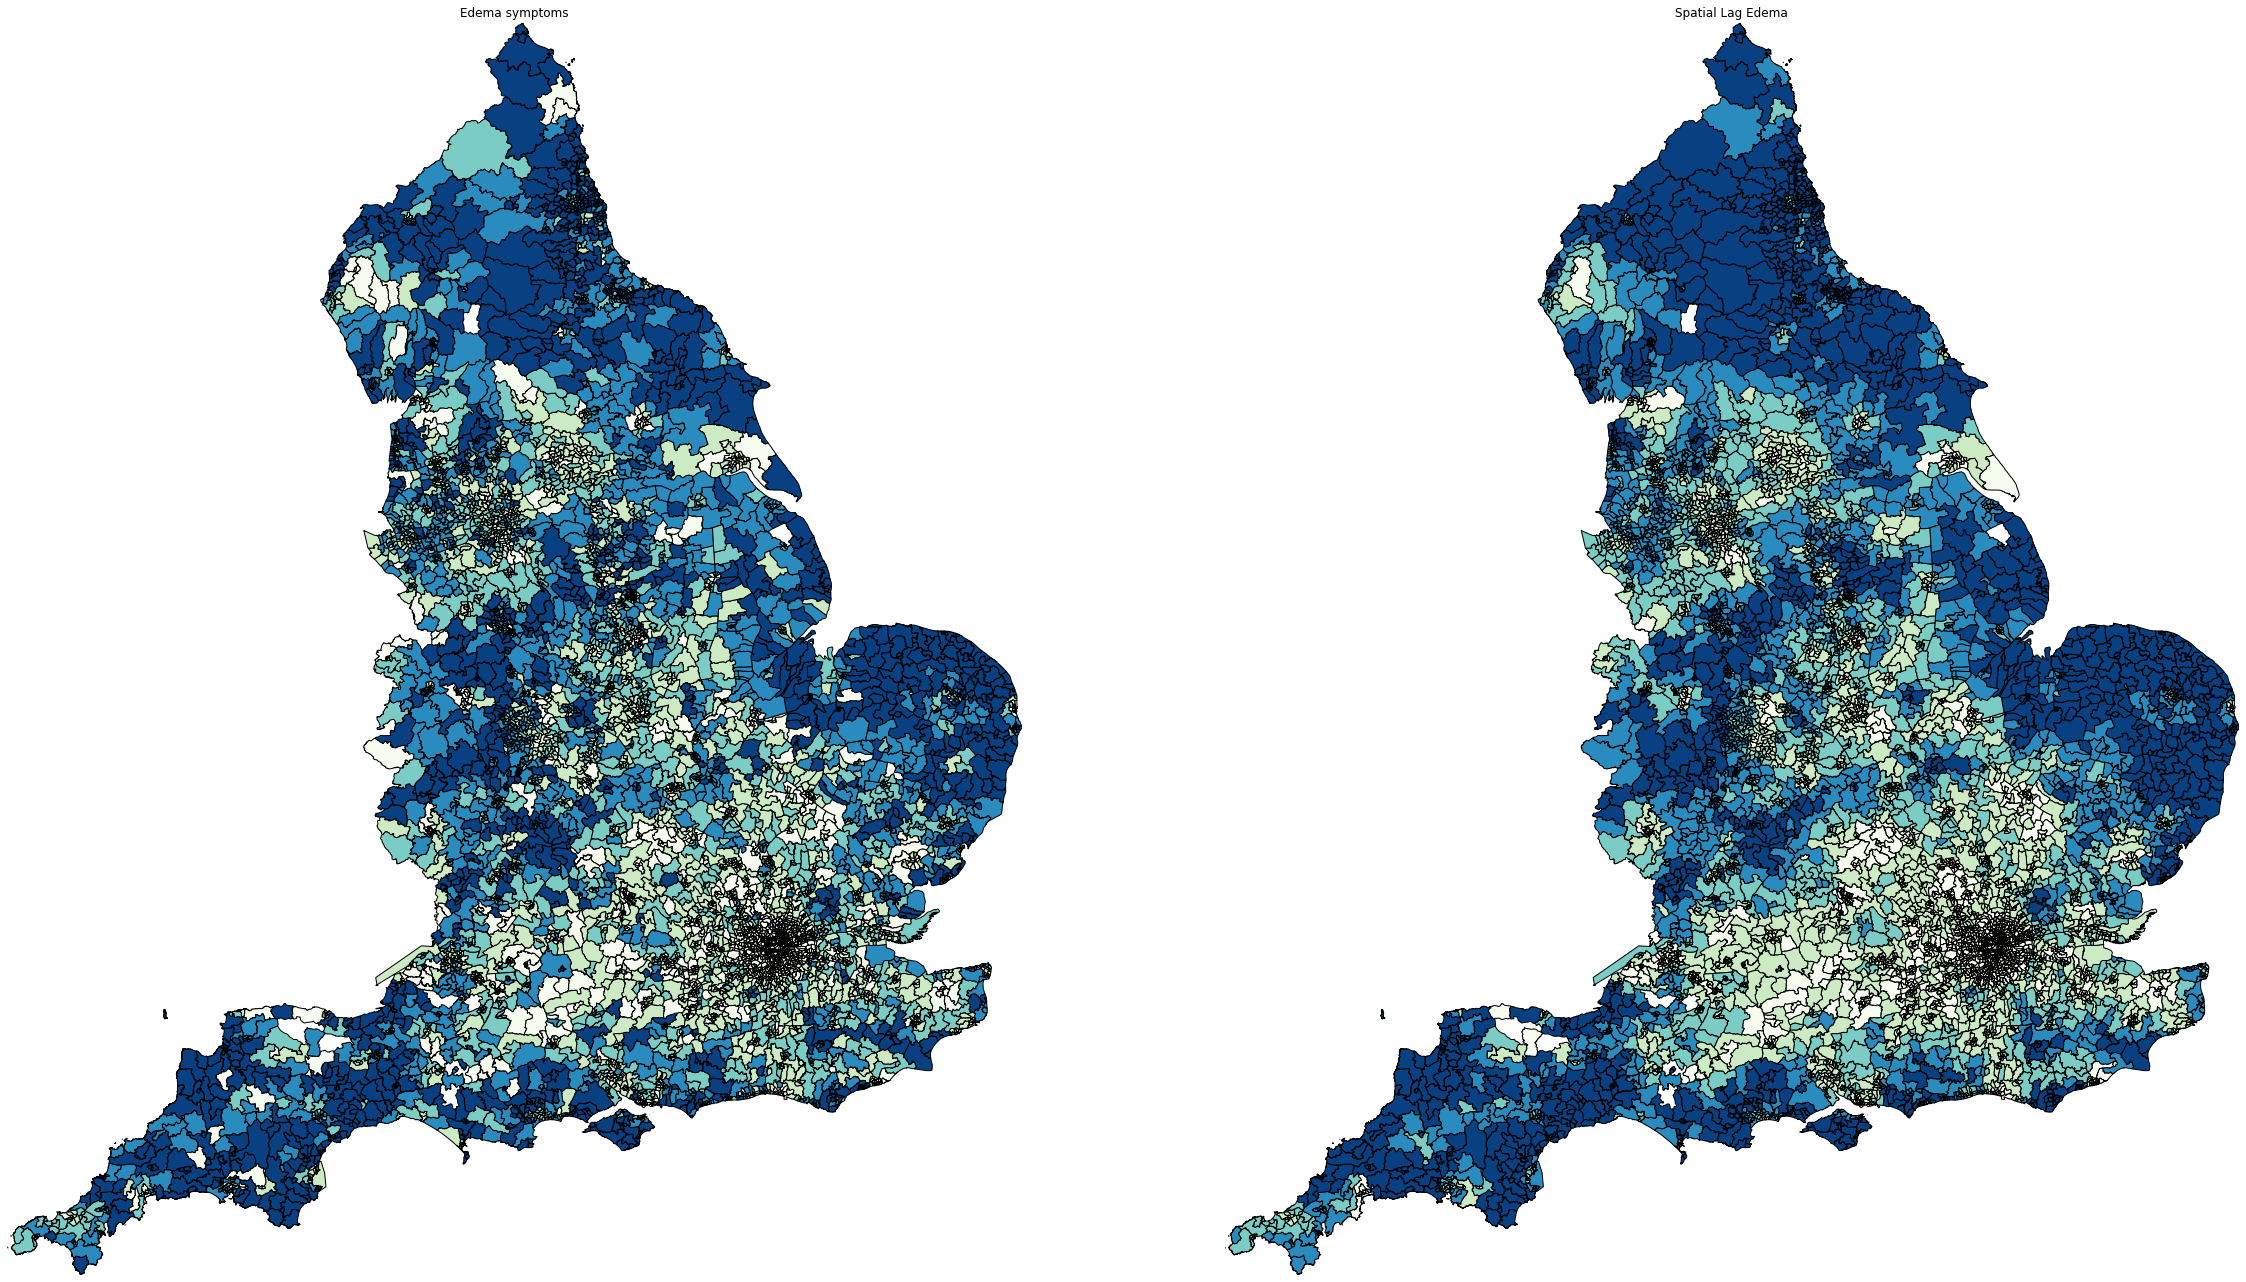

In [77]:

f, ax = plt.subplots(1,2,figsize=(40, 40))

#f,ax = plt.subplots(1,2,figsize=(2.16*4,4))
df_shape_symp_new.plot(column='symp_edema', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df_shape_symp_new.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Edema symptoms")

df_shape_symp_new.plot(column='lag_edema', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df_shape_symp_new.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Edema")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

# Global Spatial Autocorrelation¶


As proposed in PYSAL: to complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

We begin with a simple case where the variable under consideration is binary. This is useful to unpack the logic of spatial autocorrelation tests. So even though our attribute is a continuously valued one, we will convert it to a binary case to illustrate the key concepts:
Binary Case

Our value for the statistic is interpreted against a reference distribution under the null hypothesis of complete spatial randomness. PySAL uses the approach of random spatial permutations.

Here we plot Moran index on a scatterplot. 

In [80]:
y.median()
yb = y > y.median()
sum(yb)


yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df_shape_symp_new['yb'] = yb

df_shape_symp_new.head()

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,objectid,wd16cd,symp_edema,symp_heartburn,wd16nm,wd16nmw,lad16cd,lad16nm,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,lag_edema,yb
0,1,E05000026,4.399939,0.0,Abbey,None,E09000002,Barking and Dagenham,544434,184378,0.081291,51.539822,1.282923e+06,6244.885511,"POLYGON ((545296.396 184162.603, 545109.299 18...",5.682727,0 Low
1,2,E05000027,8.588602,0.0,Alibon,None,E09000002,Barking and Dagenham,549247,185196,0.150987,51.545921,1.364443e+06,6353.928980,"POLYGON ((547932.400 184916.597, 547944.800 18...",7.641201,0 Low
2,3,E05000028,8.579117,0.0,Becontree,None,E09000002,Barking and Dagenham,546863,185869,0.116912,51.552601,1.288085e+06,6341.644591,"POLYGON ((546209.396 185783.599, 546219.299 18...",7.141589,0 Low
3,4,E05000029,8.044955,0.0,Chadwell Heath,None,E09000002,Barking and Dagenham,548266,189340,0.138596,51.583420,3.384195e+06,9603.313795,"POLYGON ((548881.002 191087.601, 548877.300 19...",8.321750,0 Low
4,5,E05000030,9.404271,0.0,Eastbrook,None,E09000002,Barking and Dagenham,550774,186272,0.173453,51.555191,3.450579e+06,8987.707165,"POLYGON ((551552.897 187363.397, 551554.802 18...",9.006999,0 Low


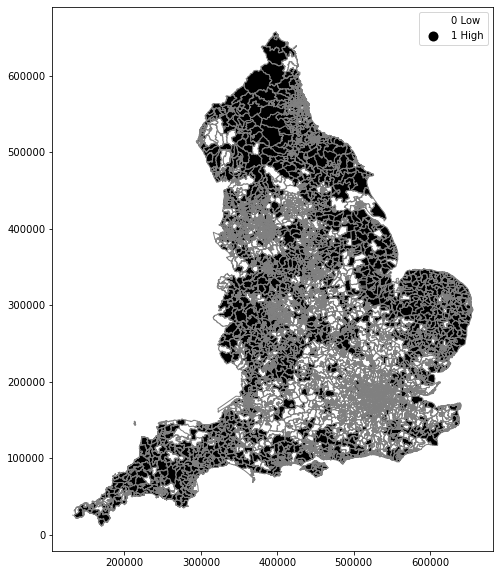

In [81]:

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df_shape_symp_new.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

# Join counts

One way to formalize a test for spatial autocorrelation in a binary attribute is to consider the so-called joins. A join exists for each neighbor pair of observations, and the joins are reflected in our binary spatial weights object wq.

Each unit can take on one of two values "Black" or "White", and so for a given pair of neighboring locations there are three different types of joins that can arise:

    Black Black (BB)
    White White (WW)
    Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black Black (BB) joins we could expect if the process were such that the Black polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the esda package from PySAL to carry out join count analysis:


In [82]:
from pysal.explore import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  lps.weights.Queen.from_dataframe(df_shape_symp_new)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\pysal\lib\weights\weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


# Continuous Case: Moran Index

The join count analysis is based on a binary attribute, which can cover many interesting empirical applications where one is interested in presence and absence type phenomena. In our case, we artificially created the binary variable, and in the process we throw away a lot of information in our originally continuous attribute. Turning back to the original variable, we can explore other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [ ]:
wq.transform = 'r'





In [83]:
y = df_shape_symp_new['symp_edema']

np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.7046603195499046

Text(0.5, 0, "Moran's I")

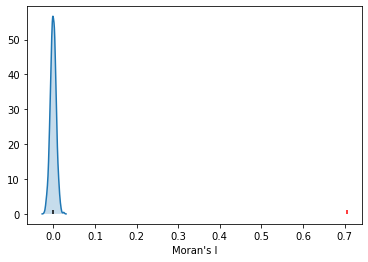

In [84]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


# Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers

In addition to the Global autocorrelation statistics, using model PySAL we can look at local autocorrelation statistics. Let's compute a local Moran statistic for the same data.


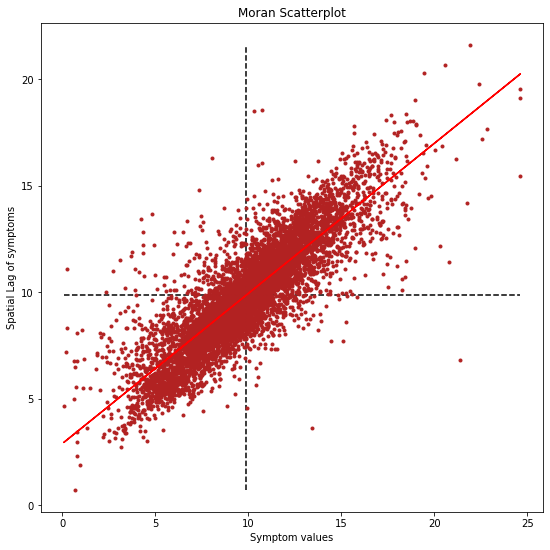

In [88]:
np.random.seed(12345)
from pysal.explore import esda

wq.transform = 'r'
lag_symp = lps.weights.lag_spatial(wq, df_shape_symp_new['symp_edema'])


symp = df_shape_symp_new['symp_edema'] #df['median_pri']
b, a = np.polyfit(symp, lag_symp, 1)

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(symp, lag_symp, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(symp.mean(), lag_symp.min(), lag_symp.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_symp.mean(), symp.min(), symp.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(symp, a + b*symp, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of symptoms')
plt.xlabel('Symptom values')
plt.show()




In [90]:
li = esda.moran.Moran_Local(y, wq)
li.q

# We can again test for local clustering using permutations, but here we use conditional random permutations (different distributions for each focal location)

(li.p_sim < 0.05).sum()

2875

The easiest way to represent Moran index is using scatterplot of spatial autocorrelation.  

**The main idea:** is to apply spatial Moran index to spatial correlation, e.g. between GDP per capita or IMD index vs.symptoms in each ward.


# Gini coefficient 
For highlighting heterogeneity and calculating a measure of degree statistical dispersion in distributions of health indices for IMD score we calculate Gini coefficient.


In [16]:

import sys
import os
sys.path.append(os.path.abspath('..'))
from pysal.explore import inequality
import pysal.lib

gini_edema = inequality.gini.Gini(df_shape_symp_new['symp_edema'])
print('gini coefficient', gini_edema.g)

gini coefficient 0.08923619747686884


C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\pandas\core\series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [17]:
inequality.gini.Gini_Spatial

pysal.explore.inequality.gini.Gini_Spatial

In [18]:
regimes = df_shape_symp_new['symp_edema']

In [19]:
w = pysal.lib.weights.block_weights(regimes)

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 7426 disconnected observations 
  Island ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 1

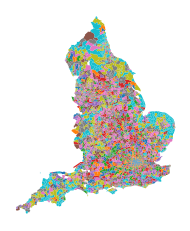

In [20]:
ax = df_shape_symp_new.plot(column='symp_edema', categorical=True)
#ax.set_title('Regions')
ax.set_axis_off()
plt.savefig('gini_spatial_edema.png')

# Results 
We calculated Gini coefficient for edema distribution 
gini coefficient 0.08923619747686884

Now we want to calculate it for IMD score